In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

drugs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-03-14/drugs.csv')

drugs['marketing_authorisation_holder_company_name'] = drugs['marketing_authorisation_holder_company_name'].str.strip()

# EDA

# Categorical Counts

In [2]:
drugs['category'].value_counts()

drugs['authorisation_status'].value_counts()

drugs['active_substance'].value_counts().nlargest(5)

meloxicam        18
adalimumab       16
olanzapine       12
bevacizumab      12
pegfilgrastim    12
Name: active_substance, dtype: int64

# Therapeutic Areas

As it can be seen, the column *therapeutic_area* contains all possible uses for each drug, separated by **";"**. Thus in order to count how many distinct therapeutic areas a drug is used for, we will need to separate the column into multiple rows based on the delimiter, **";"**.

For example, below we have all the therapeutic areas for the substance *adalimumab*.

In [3]:
therapeutic_areas = drugs.loc[drugs['active_substance']=='adalimumab', ['active_substance', 'therapeutic_area']]
therapeutic_areas = therapeutic_areas['therapeutic_area'].str.split(';  ', expand=True).stack().reset_index(level=1, drop=True).to_frame('therapeutic_area')
therapeutic_areas = therapeutic_areas.drop_duplicates()
print(therapeutic_areas)

                   therapeutic_area
6              Arthritis, Psoriatic
6    Arthritis, Juvenile Rheumatoid
6             Arthritis, Rheumatoid
6               Colitis, Ulcerative
6                     Crohn Disease
6          Hidradenitis Suppurativa
6                         Psoriasis
6           Spondylitis, Ankylosing
6                           Uveitis
111   Skin Diseases, Papulosquamous
591                       Arthritis


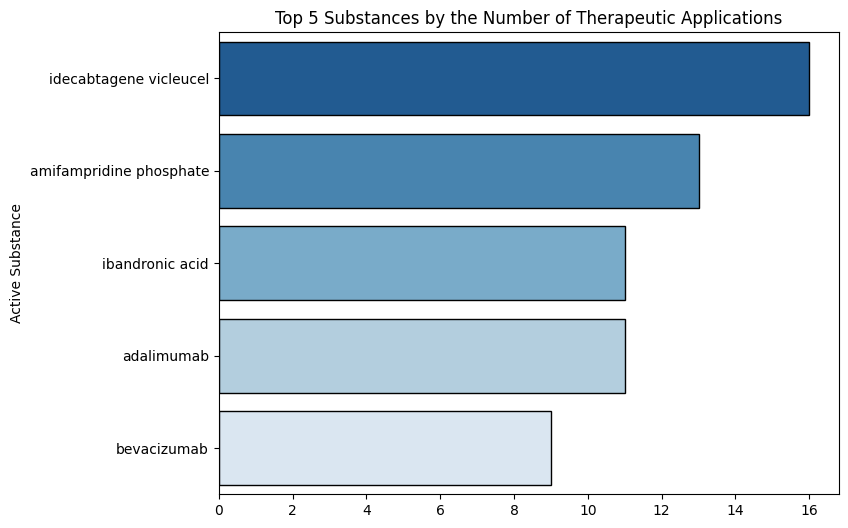

In [4]:
top_substances = (
    drugs.groupby("active_substance")["therapeutic_area"]
    .apply(lambda x: x.str.split(";  ").explode())
    .reset_index()
    .drop_duplicates(subset=["active_substance", "therapeutic_area"])
    .groupby("active_substance")
    .size()
    .reset_index(name="n")
    .sort_values("n", ascending=False)
    .head(5)
)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_substances, x="n", y="active_substance", palette="Blues_r", linewidth=1, edgecolor="black")
plt.xlabel("")
plt.ylabel("Active Substance")
plt.title("Top 5 Substances by the Number of Therapeutic Applications")


plt.show()

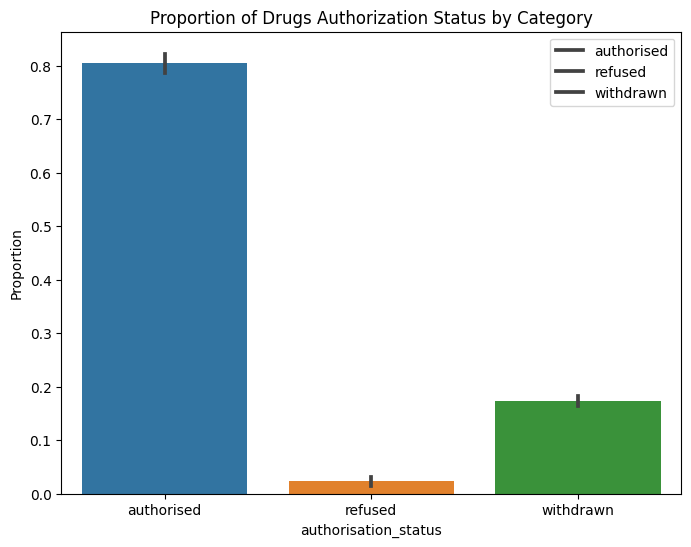

In [5]:
df = drugs.dropna(subset=["authorisation_status"]).copy()  
df["count"] = 1
authorization_proportions = df.pivot_table(
    index="category", columns="authorisation_status", values="count", aggfunc="sum", fill_value=0
).apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(8, 6))
sns.barplot(data=authorization_proportions)
plt.ylabel("Proportion")
plt.title("Proportion of Drugs Authorization Status by Category")
plt.legend(title="", labels=authorization_proportions.columns)

plt.show()

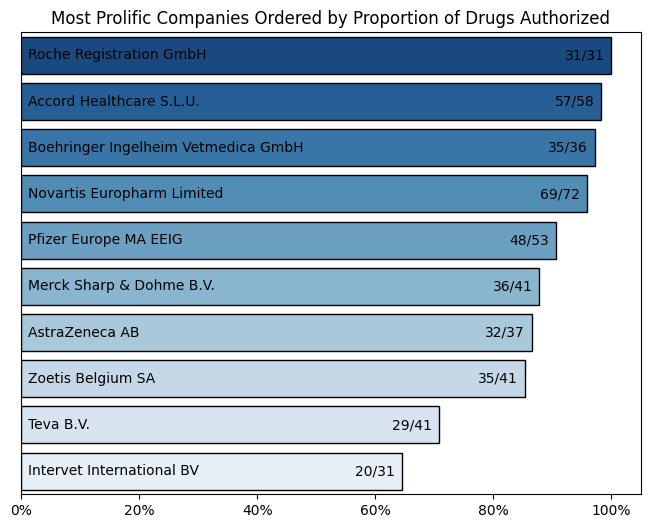

In [5]:
company_stats = (
    drugs.groupby("marketing_authorisation_holder_company_name")
    .agg(n=("marketing_authorisation_holder_company_name", "count"), prop=("authorisation_status", lambda x: (x == "authorised").mean()))
    .sort_values(by=["n", "prop"], ascending=False)
    .reset_index()
    .head(10)
)

# Reorder based on the proportion
company_stats = company_stats.sort_values(by="prop", ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(
    data=company_stats, x="prop", y="marketing_authorisation_holder_company_name", palette="Blues_r", linewidth=1, edgecolor="black", ax=ax
)
plt.ylabel("")
plt.xlabel("")
plt.title("Most Prolific Companies Ordered by Proportion of Drugs Authorized")

# Add text labels
for index, bar in enumerate(ax.containers[0].patches):
    value = f"{company_stats.iloc[index]['prop'] * company_stats.iloc[index]['n']:.0f}/{company_stats.iloc[index]['n']}"
    ax.annotate(value, (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='right', va='center', color='black', xytext=(-5, 0), textcoords='offset points')
    ax.annotate(company_stats.iloc[index]['marketing_authorisation_holder_company_name'], (0, bar.get_y() + bar.get_height() / 2), ha='left', va='center', color='black', xytext=(5, 0), textcoords='offset points')

plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()
